# Homesite Quote Conversion <a id='goback'> </a>
![image.png](Homesite_image.png) 

**Background** <br>
This dataset represents the activity of a large number of customers who are interested in buying policies from Homesite. Each QuoteNumber corresponds to a potential customer and the QuoteConversion_Flag indicates whether the customer purchased a policy.
<br>
The provided features are anonymized and provide a rich representation of the prospective customer and policy. They include specific coverage information, sales information, personal information, property information, and geographic information. Your task is to predict QuoteConversion_Flag for each QuoteNumber in the test set.

**References** <br>
    - [Pandas Library](https://pandas.pydata.org/docs/index.html) <br>
    - [SkLearn Library](https://scikit-learn.org/stable/) <br>
    - [SMOTE API](https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTE.html) <br>
    - [Stacking Library](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html) <br>
    - [Kaggle Dataset](https://www.kaggle.com/competitions/homesite-quote-conversion/data?select=test.csv.zip) <br>

**Notebook Index**
- [Data Import](#dataimport)
- [Data Preprocessing](#preprocess)
    - [One Hot Encoding : Categorical Values](#ohe)
    - [Handling Imbalanced Datasets](#imbalance)
- [Effect of SMOTE on a classification model ](#smote)
- [Accuracy Comparison](#acccompare)
    - [Multiple Model Development](#multiple)
    - [Ensemble Method : Stacking](#ensemble)
    - [Accuracy Report](#acc)
- [Kaggle Submission](#kag)
    - [Multiple Model Development with HyperParameter Tuning](#multiple2)
    - [Ensemble Method : Stacking](#ensemble2)
    - [Kaggle Report](#kag2)

In [1]:
#Libraries
# Data Manipulation
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sn

# Imbalanced Data
from imblearn.over_sampling import RandomOverSampler,SMOTE
from imblearn.under_sampling import RandomUnderSampler,NearMiss

# Machine Learning 
import sklearn
from sklearn import metrics
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,roc_auc_score,roc_curve,mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC,SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# Hyper Parameter Tuning
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

# Stacking
from vecstack import stacking

import warnings
warnings.filterwarnings("ignore")

# Function to evaluate the model results
def evaluate_model(model,xtrain,xtest,ytrain,ytest):
    model.fit(xtrain,ytrain)
    ypred=model.predict(xtest)
    
    print(model)
    print("Testing Accuracy Score: ",accuracy_score(ytest,ypred))
    print()
    print("Classification Report: \n",classification_report(ytest,ypred))
    print()

# SMOTEing on Training data only and Accuracy with YTest
def evaluate_modeL_smote(model,X,Y,k):
    #If k=0 , no oversmapling required
    
    Xtrain,Xtest,Ytrain,Ytest=train_test_split(X,Y,test_size=0.3)
    
    # SMOTEingonly on Train part of Train_df
    if k!=0: 
        sm=SMOTE(sampling_strategy=k)
        SMOTE_X,SMOTE_Y=sm.fit_resample(Xtrain,Ytrain)
    else:
        SMOTE_X=Xtrain
        SMOTE_Y=Ytrain
    
    # Fitting using SMOTE_X,SMOTE_Y
    model.fit(SMOTE_X,SMOTE_Y)
    YPred=model.predict(Xtest)
    
    print(model)
    print("\nSMOTE sampling_strategy:",k)
    print("Testing Accuracy Score: ",accuracy_score(Ytest,YPred))

## Data Import <a id='dataimport'> </a>

In [2]:
TrainingFile_loc=r'Data/RevisedHomesiteTrain1.csv'
Train_df=pd.read_csv(TrainingFile_loc)

TestingFile_loc=r'Data/RevisedHomesiteTest1.csv'
Test_df=pd.read_csv(TestingFile_loc)

Train_df.head()

,CoverageField11A,CoverageField11B,CoverageField1A,CoverageField1B,CoverageField2A,CoverageField2B,CoverageField3A,CoverageField3B,CoverageField4A,CoverageField4B,...,PropertyField38_N,PropertyField38_Y,GeographicField63_,GeographicField63_N,GeographicField63_Y,GeographicField64_CA,GeographicField64_IL,GeographicField64_NJ,GeographicField64_TX,QuoteConversion_Flag
0,2,1,17,23,17,23,15,22,16,22,...,1,0,0,1,0,1,0,0,0,0
1,5,9,6,8,6,8,5,7,5,8,...,1,0,0,1,0,0,0,1,0,0
2,4,6,7,12,7,12,6,10,7,11,...,1,0,0,1,0,0,0,1,0,0
3,15,23,3,2,3,2,2,2,3,2,...,1,0,0,1,0,0,0,0,1,0
4,4,6,8,13,8,13,7,11,7,13,...,1,0,0,1,0,0,1,0,0,0


In [3]:
Test_df.head()

,CoverageField11A,CoverageField11B,CoverageField1A,CoverageField1B,CoverageField2A,CoverageField2B,CoverageField3A,CoverageField3B,CoverageField4A,CoverageField4B,...,PropertyField38_N,PropertyField38_Y,GeographicField63_,GeographicField63_N,GeographicField63_Y,GeographicField64_CA,GeographicField64_IL,GeographicField64_NJ,GeographicField64_TX,GeographicField64
0,13,22,4,4,4,4,3,3,3,4,...,1,0,0,0,1,0,0,0,0,IL
1,4,5,8,14,8,14,7,12,8,13,...,1,0,0,1,0,0,0,0,0,NJ
2,3,3,11,18,11,18,10,16,10,18,...,1,0,0,1,0,0,0,0,0,NJ
3,5,9,14,22,15,22,13,20,22,25,...,1,0,0,1,0,0,0,0,0,TX
4,12,21,4,5,4,5,4,4,4,5,...,1,0,0,1,0,0,0,0,0,CA


`[Go Back to Index](#goback)

## Data Preprocessing <a id="preprocess"> </a>
One Hot Encoding for Categorical Datapoints <a id='ohe'> </a>

In [4]:
# Issue in Encoding GrographicalField64 
# Drop
Test_df.drop(["GeographicField64_CA","GeographicField64_IL","GeographicField64_NJ","GeographicField64_TX"],axis=1,inplace=True)

# Perform OneHotEncoding to Code location IL,NJ,TX,CA
from sklearn.preprocessing import OneHotEncoder
GeoFieldEnc=OneHotEncoder(sparse=False,handle_unknown='ignore')
EncodedValues=pd.DataFrame(GeoFieldEnc.fit_transform(Test_df[['GeographicField64']]),
                           columns=GeoFieldEnc.get_feature_names_out())

Test_df=pd.concat([Test_df,EncodedValues],axis=1)
Test_df
#Dropping a categorical column 
Test_df.drop("GeographicField64",axis=1,inplace=True)

In [5]:
Test_df.head()

,CoverageField11A,CoverageField11B,CoverageField1A,CoverageField1B,CoverageField2A,CoverageField2B,CoverageField3A,CoverageField3B,CoverageField4A,CoverageField4B,...,PropertyField37_Y,PropertyField38_N,PropertyField38_Y,GeographicField63_,GeographicField63_N,GeographicField63_Y,GeographicField64_CA,GeographicField64_IL,GeographicField64_NJ,GeographicField64_TX
0,13,22,4,4,4,4,3,3,3,4,...,1,1,0,0,0,1,0.0,1.0,0.0,0.0
1,4,5,8,14,8,14,7,12,8,13,...,0,1,0,0,1,0,0.0,0.0,1.0,0.0
2,3,3,11,18,11,18,10,16,10,18,...,0,1,0,0,1,0,0.0,0.0,1.0,0.0
3,5,9,14,22,15,22,13,20,22,25,...,0,1,0,0,1,0,0.0,0.0,0.0,1.0
4,12,21,4,5,4,5,4,4,4,5,...,0,1,0,0,1,0,1.0,0.0,0.0,0.0


Successfully encoded GrographicalField64!

Drop any Row Duplicates 

In [6]:
Train_df.shape

(65000, 596)

In [7]:
Train_df.drop_duplicates()
Train_df.shape

(65000, 596)

In [8]:
Test_df.shape

(173836, 595)

No Row Duplicates found

Search for any null values in the datasets

In [9]:
Train_df.isnull().sum().sort_values(ascending=False)

CoverageField11A        0
PersonalField17_YU      0
PersonalField17_YW      0
PersonalField17_YX      0
PersonalField17_YY      0
                       ..
PersonalField64         0
PersonalField65         0
PersonalField66         0
PersonalField67         0
QuoteConversion_Flag    0
Length: 596, dtype: int64

No Null values in the dataset

(0    52738
 1    12262
 Name: QuoteConversion_Flag, dtype: int64,
 <AxesSubplot:ylabel='QuoteConversion_Flag'>)

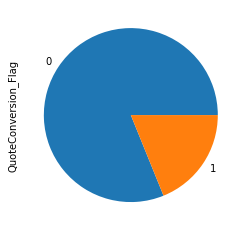

In [10]:
X=Train_df.drop("QuoteConversion_Flag",axis=1)
Y=Train_df["QuoteConversion_Flag"]

Y.value_counts(), Y.value_counts().plot.pie()

`[Go Back to Index](#goback)

### Handling Imbalanced Datasets <a id='imbalance'> </a>
- Random Under Sampling
- Random Over Sampling
- **SMOTE**: Synthetic Minority Oversampling Technique

In [11]:
#Random Under-Sampling
# rus=RandomUnderSampler(sampling_strategy=1)
# X_rus,Y_rus=rus.fit_resample(X,Y)
# Y_rus.value_counts(), Y_rus.value_counts().plot.pie()

# # Near Miss Under Sampling 
# # Three Methods : 
# Nearmiss1: K nearest neighbours having smallest avg distance,
# Nearmiss K neighbours farthest having smallest avg distance2,nearmiss 3
# nmus=NearMiss(sampling_strategy=1)
# X_nmus,Y_nmus=nmus.fit_resample(X,Y)
# Y_nmus.value_counts().plot.pie()

(0    52738
 1    52738
 Name: QuoteConversion_Flag, dtype: int64,
 <AxesSubplot:ylabel='QuoteConversion_Flag'>)

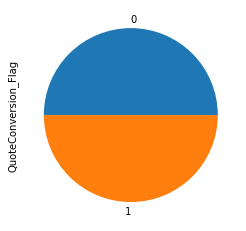

In [12]:
#Random Over-Sampling
# rus=RandomOverSampler(sampling_strategy=1)
# X_ros,Y_ros=rus.fit_resample(X,Y)
# Y_ros.value_counts(), Y_ros.value_counts().plot.pie()

#Synethetic Minority Oversampling Technique : SMOTE
sm=SMOTE(sampling_strategy=1)
X_sm,Y_sm=sm.fit_resample(X,Y)
Y_sm.value_counts(), Y_sm.value_counts().plot.pie()

`[Go Back to Index](#goback)

## Effect of SMOTE on a classification model <a id='smote'> </a>

In [13]:
# Model1 : Decision Tree
M1=DecisionTreeClassifier()
#No SMOTE
evaluate_modeL_smote(M1,X,Y,0)

DecisionTreeClassifier()

SMOTE sampling_strategy: 0
Testing Accuracy Score:  0.8777948717948718


In [14]:
# Model1 : Decision Tree
M12=DecisionTreeClassifier()
evaluate_modeL_smote(M12,X,Y,1)

DecisionTreeClassifier()

SMOTE sampling_strategy: 1
Testing Accuracy Score:  0.8746666666666667


In [15]:
M13=DecisionTreeClassifier()
evaluate_modeL_smote(M13,X,Y,0.8)

DecisionTreeClassifier()

SMOTE sampling_strategy: 0.8
Testing Accuracy Score:  0.8748205128205129


In [16]:
M14=DecisionTreeClassifier()
evaluate_modeL_smote(M14,X,Y,0.5)

DecisionTreeClassifier()

SMOTE sampling_strategy: 0.5
Testing Accuracy Score:  0.880051282051282


`[Go Back to Index](#goback)

## Accuracy Comparison <a id='acccompare'> </a>
### Multiple Model Development <a id='multiple'> </a>
- We use a sampling_strategy of 1 as it provides us with equal instances of both classes
- Developing 5 Models : Decision Tree, Random Forest, Support Vector Machine, KNN Classfier, Neural Nets MPT

In [17]:
%%time
#With Test_Train Split function
Xtrain,Xtest,Ytrain,Ytest=train_test_split(X,Y,test_size=0.3)

sm=SMOTE(sampling_strategy=1)
SMOTE_X,SMOTE_Y=sm.fit_resample(Xtrain,Ytrain)

# Model1 : Decision Tree
M1=DecisionTreeClassifier()
evaluate_model(M1,SMOTE_X,Xtest,SMOTE_Y,Ytest)

DecisionTreeClassifier()
Testing Accuracy Score:  0.8755897435897436

Classification Report: 
               precision    recall  f1-score   support

           0       0.93      0.92      0.92     15761
           1       0.67      0.69      0.68      3739

    accuracy                           0.88     19500
   macro avg       0.80      0.80      0.80     19500
weighted avg       0.88      0.88      0.88     19500


CPU times: total: 16.6 s
Wall time: 9.67 s


In [18]:
%%time
# Model2 : Random Forest Classifier
M2=RandomForestClassifier()
evaluate_model(M2,SMOTE_X,Xtest,SMOTE_Y,Ytest)

RandomForestClassifier()
Testing Accuracy Score:  0.8991282051282051

Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.96      0.94     15761
           1       0.80      0.63      0.70      3739

    accuracy                           0.90     19500
   macro avg       0.86      0.80      0.82     19500
weighted avg       0.89      0.90      0.89     19500


CPU times: total: 25 s
Wall time: 25.2 s


In [19]:
%%time
# Model3 : Support Vector Machine
M3=LinearSVC()
evaluate_model(M3,SMOTE_X,Xtest,SMOTE_Y,Ytest)

LinearSVC()
Testing Accuracy Score:  0.3993333333333333

Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.27      0.42     15761
           1       0.24      0.96      0.38      3739

    accuracy                           0.40     19500
   macro avg       0.60      0.61      0.40     19500
weighted avg       0.82      0.40      0.41     19500


CPU times: total: 54.6 s
Wall time: 54.8 s


In [20]:
%%time
# Model4 : KNN Classifier
M4=KNeighborsClassifier()
evaluate_model(M4,SMOTE_X,Xtest,SMOTE_Y,Ytest)

KNeighborsClassifier()
Testing Accuracy Score:  0.5792307692307692

Classification Report: 
               precision    recall  f1-score   support

           0       0.82      0.61      0.70     15761
           1       0.21      0.43      0.28      3739

    accuracy                           0.58     19500
   macro avg       0.52      0.52      0.49     19500
weighted avg       0.70      0.58      0.62     19500


CPU times: total: 3min 18s
Wall time: 21.5 s


In [21]:
# Model5 : Neural Nets
M5=MLPClassifier()
evaluate_model(M5,SMOTE_X,Xtest,SMOTE_Y,Ytest)

MLPClassifier()
Testing Accuracy Score:  0.8347692307692308

Classification Report: 
               precision    recall  f1-score   support

           0       0.83      0.99      0.91     15761
           1       0.86      0.16      0.28      3739

    accuracy                           0.83     19500
   macro avg       0.85      0.58      0.59     19500
weighted avg       0.84      0.83      0.79     19500




`[Go Back to Index](#goback)

### Ensemble Method <a id='ensemble'> </a>
Stacking 5 models and taking RandomForestClassifier as Top Level Model

In [22]:
%%time
# Stacking 5 models using just Train_df

print("__________________________________________STACKING with TestTrainSplit______________________________________________")

# models=[M1,M2,M3,M4,M5]
models=[DecisionTreeClassifier(),RandomForestClassifier(),LinearSVC(),KNeighborsClassifier(),MLPClassifier()]

S_train,S_Test=stacking(models,
                        SMOTE_X,SMOTE_Y,Xtest,
                        shuffle=True,
                        regression=False,
                        metric=accuracy_score,
                        verbose=2
                       )

FinalModel=RandomForestClassifier()
FinalModel.fit(S_train,SMOTE_Y)
ypred_train=FinalModel.predict(S_train)
ypred_test=FinalModel.predict(S_Test)

print("Training Accuracy:",accuracy_score(SMOTE_Y,ypred_train))
print("Testing Accuracy:",accuracy_score(Ytest,ypred_test))
    
print("Mean Square Error Train:",mean_squared_error(SMOTE_Y,ypred_train))
print("Mean Square Error Test:",mean_squared_error(Ytest,ypred_test))

__________________________________________STACKING with TestTrainSplit______________________________________________
task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [5]

model  0:     [DecisionTreeClassifier]
    fold  0:  [0.92043918]
    fold  1:  [0.91762670]
    fold  2:  [0.92200346]
    fold  3:  [0.91756815]
    ----
    MEAN:     [0.91940937] + [0.00189459]
    FULL:     [0.91940936]

model  1:     [RandomForestClassifier]
    fold  0:  [0.94082968]
    fold  1:  [0.93844989]
    fold  2:  [0.94250325]
    fold  3:  [0.93974470]
    ----
    MEAN:     [0.94038188] + [0.00148655]
    FULL:     [0.94038186]

model  2:     [LinearSVC]
    fold  0:  [0.54800151]
    fold  1:  [0.57309752]
    fold  2:  [0.55798356]
    fold  3:  [0.70651233]
    ----
    MEAN:     [0.59639873] + [0.06419885]
    FULL:     [0.59639776]

model  3:     [KNeighborsClassifier]
    fold  0:  [0.72302450]
    fold  1:  [0.72291633]

`[Go Back to Index](#goback)

## Accuracy Comparison <a id='acc'> </a>
Using train_test_split on Train_df

|S No.| Model Name | Type of Model | SMOTE strategy | HyperParameter Tuning | Accuracy  |
|:-:| :---- | :---: | :---: |:---: |:---: |
|1.| Decision Tree M1 | Individual |1|None| 0.87 |
|2.| Random Forest Classifier M2 | Individual |1|None| <span style="color:red">0.89</span> |
|3.| LinearSVC Classifier M3 | Individual |1|None| 0.34 |
|4.| KNeighborsClassifier M4 | Individual |1|None| 0.57 |
|5.| MLP Classifier M5 | Individual |1|None| 0.80 |
| | | | | | |
|6.| **RandomForestClassifier** | **Stacked** |**1**|**None**| **0.89** |


`[Go Back to Index](#goback)

## Kaggle Submission <a id='kag'> </a>
### Multiple Model Development <a id='multiple2'> </a>
- Training models using SMOTEd Training data: X_sm, Y_sm <br>
- Testing models using Test_df <br>
- Sampling_strategy of 1 has been used for X_sm,Y_sm
- Developing 5 Models : Decision Tree, Random Forest, Support Vector Machine, KNN Classfier, Neural Nets MPT
- Hyper Parameter Tuning using RandomizedSeachCV method

In [23]:
%%time
# Decision Tree
M6=DecisionTreeClassifier()
# M6.fit(X_sm,Y_sm)

# RandomCV Hyper Parameter Tuning
param6={'criterion':['gini', 'entropy'],
        'splitter':['best','random'],
       'max_depth':range(1,20,1)}
rcv=RandomizedSearchCV(M6,param6,verbose=2)
rcv.fit(X_sm,Y_sm)
print("Best set of parameters for dt: ",rcv.best_params_,
      "\nBest Score : ",rcv.best_score_)
parambest=rcv.best_params_

M6=DecisionTreeClassifier(**parambest)
M6.fit(X_sm,Y_sm)
Output6=M6.predict_proba(Test_df)

# Export as CSV
sub=pd.read_csv("Data/sample_submission.csv")
output=pd.concat([sub["QuoteNumber"],pd.DataFrame(Output6[:,1],columns=["QuoteConversion_Flag"])],axis=1)
output.to_csv("M6_KaggleSubmissionAssignment3.csv",index=False)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END .......criterion=gini, max_depth=5, splitter=random; total time=   2.9s
[CV] END .......criterion=gini, max_depth=5, splitter=random; total time=   2.6s
[CV] END .......criterion=gini, max_depth=5, splitter=random; total time=   1.8s
[CV] END .......criterion=gini, max_depth=5, splitter=random; total time=   1.8s
[CV] END .......criterion=gini, max_depth=5, splitter=random; total time=   2.0s
[CV] END ...criterion=entropy, max_depth=11, splitter=random; total time=   2.9s
[CV] END ...criterion=entropy, max_depth=11, splitter=random; total time=   3.2s
[CV] END ...criterion=entropy, max_depth=11, splitter=random; total time=   3.4s
[CV] END ...criterion=entropy, max_depth=11, splitter=random; total time=   3.4s
[CV] END ...criterion=entropy, max_depth=11, splitter=random; total time=   3.6s
[CV] END ......criterion=entropy, max_depth=8, splitter=best; total time=   4.7s
[CV] END ......criterion=entropy, max_depth=8, s

FileNotFoundError: [Errno 2] No such file or directory: 'sample_submission.csv'

In [24]:
%%time
# Random Forest
M7=RandomForestClassifier()
# M7.fit(X_sm,Y_sm)

# RandomCV Hyper Parameter Tuning
param7={'n_estimators':range(10,200,2),
        'criterion':['gini', 'entropy'],
       'max_depth':range(1,20,2)}
rcv7=RandomizedSearchCV(M7,param7,verbose=2)
rcv7.fit(X_sm,Y_sm)
print("Best set of parameters for dt: ",rcv7.best_params_,
      "\nBest Score : ",rcv7.best_score_)
parambest=rcv7.best_params_

M7=RandomForestClassifier(**parambest)
M7.fit(X_sm,Y_sm)
Output7=M7.predict_proba(Test_df)

# Export as CSV
sub=pd.read_csv("Data/sample_submission.csv")
output=pd.concat([sub["QuoteNumber"],pd.DataFrame(Output7[:,1],columns=["QuoteConversion_Flag"])],axis=1)
output.to_csv("M7_KaggleSubmissionAssignment3.csv",index=False)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END .......criterion=gini, max_depth=9, n_estimators=28; total time=   4.4s
[CV] END .......criterion=gini, max_depth=9, n_estimators=28; total time=   4.2s
[CV] END .......criterion=gini, max_depth=9, n_estimators=28; total time=   4.2s
[CV] END .......criterion=gini, max_depth=9, n_estimators=28; total time=   4.2s
[CV] END .......criterion=gini, max_depth=9, n_estimators=28; total time=   4.2s
[CV] END ......criterion=gini, max_depth=15, n_estimators=98; total time=  20.9s
[CV] END ......criterion=gini, max_depth=15, n_estimators=98; total time=  21.6s
[CV] END ......criterion=gini, max_depth=15, n_estimators=98; total time=  22.2s
[CV] END ......criterion=gini, max_depth=15, n_estimators=98; total time=  22.0s
[CV] END ......criterion=gini, max_depth=15, n_estimators=98; total time=  22.4s
[CV] END ......criterion=gini, max_depth=15, n_estimators=72; total time=  15.7s
[CV] END ......criterion=gini, max_depth=15, n_e

FileNotFoundError: [Errno 2] No such file or directory: 'sample_submission.csv'

In [25]:
%%time
# Linear SVM
M8=LinearSVC()
# M8.fit(X_sm,Y_sm)

# RandomCV Hyper Parameter Tuning
param8={'max_iter':range(200,2000,200)}

rcv8=RandomizedSearchCV(M8,param8,verbose=2)
rcv8.fit(X_sm,Y_sm)
print("Best set of parameters for dt: ",rcv8.best_params_,
      "\nBest Score : ",rcv8.best_score_)
parambest=rcv8.best_params_

M8=LinearSVC(**parambest)
M8.fit(X_sm,Y_sm)
Output8=M8.predict(Test_df)

# Export as CSV
sub=pd.read_csv("sample_submission.csv")
output=pd.concat([sub["QuoteNumber"],pd.DataFrame(Output8,columns=["QuoteConversion_Flag"])],axis=1)
output.to_csv("M8_KaggleSubmissionAssignment3.csv",index=False)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END .......................................max_iter=200; total time=  15.6s
[CV] END .......................................max_iter=200; total time=  15.4s
[CV] END .......................................max_iter=200; total time=  15.5s
[CV] END .......................................max_iter=200; total time=  16.8s
[CV] END .......................................max_iter=200; total time=  15.6s
[CV] END .......................................max_iter=400; total time=  30.3s
[CV] END .......................................max_iter=400; total time=  41.0s
[CV] END .......................................max_iter=400; total time=  34.9s
[CV] END .......................................max_iter=400; total time=  31.1s
[CV] END .......................................max_iter=400; total time=  30.9s
[CV] END .......................................max_iter=600; total time=  45.7s
[CV] END .......................................m

FileNotFoundError: [Errno 2] No such file or directory: 'sample_submission.csv'

In [26]:
%%time
# KNN Classifier
M9=KNeighborsClassifier()
M9.fit(X_sm,Y_sm)

# RandomCV Hyper Parameter Tuning
param9={'n_neighbors':range(3,13,2),
        'weights':['uniform', 'distance'],
       'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']}
rcv9=RandomizedSearchCV(M9,param9,verbose=2)
rcv9.fit(X_sm,Y_sm)
print("Best set of parameters for dt: ",rcv9.best_params_,
      "\nBest Score : ",rcv9.best_score_)
parambest=rcv9.best_params_

M9=KNeighborsClassifier(**parambest)
M9.fit(X_sm,Y_sm)
Output9=M9.predict_proba(Test_df)

# Export as CSV
sub=pd.read_csv("sample_submission.csv")
output=pd.concat([sub["QuoteNumber"],pd.DataFrame(Output9[:,1],columns=["QuoteConversion_Flag"])],axis=1)
output.to_csv("M9_KaggleSubmissionAssignment3.csv",index=False)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ....algorithm=auto, n_neighbors=7, weights=distance; total time=  43.7s
[CV] END ....algorithm=auto, n_neighbors=7, weights=distance; total time=  44.9s
[CV] END ....algorithm=auto, n_neighbors=7, weights=distance; total time=  43.8s
[CV] END ....algorithm=auto, n_neighbors=7, weights=distance; total time=  43.1s
[CV] END ....algorithm=auto, n_neighbors=7, weights=distance; total time=  45.0s
[CV] END ....algorithm=brute, n_neighbors=3, weights=uniform; total time=  52.1s
[CV] END ....algorithm=brute, n_neighbors=3, weights=uniform; total time=  45.5s
[CV] END ....algorithm=brute, n_neighbors=3, weights=uniform; total time=  43.3s
[CV] END ....algorithm=brute, n_neighbors=3, weights=uniform; total time=  43.9s
[CV] END ....algorithm=brute, n_neighbors=3, weights=uniform; total time=  41.9s
[CV] END ..algorithm=brute, n_neighbors=11, weights=distance; total time=  43.3s
[CV] END ..algorithm=brute, n_neighbors=11, weig

FileNotFoundError: [Errno 2] No such file or directory: 'sample_submission.csv'

In [27]:
%%time
# MLP Classifier
M10=MLPClassifier()
# M10.fit(X_sm,Y_sm)

# RandomCV Hyper Parameter Tuning
param10={'hidden_layer_sizes':[(10,),(20,),(40,),(60,),(80,),(100,)],
        'activation':['identity', 'logistic','tanh','relu'],
        'solver':['sgd','adam'],
        'learning_rate':['constant', 'invscaling','adaptive']}
rcv10=RandomizedSearchCV(M10,param10,verbose=2)
rcv10.fit(X_sm,Y_sm)
print("Best set of parameters for dt: ",rcv10.best_params_,
      "\nBest Score : ",rcv10.best_score_)
parambest=rcv10.best_params_

M10=MLPClassifier(**parambest)
M10.fit(X_sm,Y_sm)
Output10=M10.predict_proba(Test_df)

# Export as CSV
sub=pd.read_csv("Data/sample_submission.csv")
output=pd.concat([sub["QuoteNumber"],pd.DataFrame(Output10[:,1],columns=["QuoteConversion_Flag"])],axis=1)
output.to_csv("M10_KaggleSubmissionAssignment3.csv",index=False)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END activation=identity, hidden_layer_sizes=(40,), learning_rate=adaptive, solver=adam; total time=  38.9s
[CV] END activation=identity, hidden_layer_sizes=(40,), learning_rate=adaptive, solver=adam; total time=  35.5s
[CV] END activation=identity, hidden_layer_sizes=(40,), learning_rate=adaptive, solver=adam; total time=  47.8s
[CV] END activation=identity, hidden_layer_sizes=(40,), learning_rate=adaptive, solver=adam; total time=  22.9s
[CV] END activation=identity, hidden_layer_sizes=(40,), learning_rate=adaptive, solver=adam; total time=  52.7s
[CV] END activation=identity, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam; total time=  23.3s
[CV] END activation=identity, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam; total time=  21.9s
[CV] END activation=identity, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam; total time=  19.1s
[CV] END activation=identity, hidden_layer_

FileNotFoundError: [Errno 2] No such file or directory: 'sample_submission.csv'

`[Go Back to Index](#goback)

### Ensemble Method <a id='ensemble2'> </a>
Stacking 5 models and taking RandomForestClassifier and DecisionTree as Top Level Model

In [28]:
# Stacking
# Level 0 Models
models=[RandomForestClassifier(),
        DecisionTreeClassifier(),
        KNeighborsClassifier(),
        LinearSVC(),
        MLPClassifier()]

# We can also use our hyper parameter tuned individual modesl as input for stacking
# models=[M6,M7,M8,M9,M10]
# models=[M6,M7,M10]

S_Train_hp,S_Test_hp=stacking(models,
                             X_sm,Y_sm,Test_df,
                             shuffle=True,
                             stratified=True,
                             n_folds=4,
                             regression=False,
                             metric=accuracy_score,
                             verbose=2)
print('Stacking Complete!')

task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [5]

model  0:     [RandomForestClassifier]
    fold  0:  [0.94027077]
    fold  1:  [0.93981569]
    fold  2:  [0.94042247]
    fold  3:  [0.94174978]
    ----
    MEAN:     [0.94056468] + [0.00071973]
    FULL:     [0.94056468]

model  1:     [DecisionTreeClassifier]
    fold  0:  [0.92092988]
    fold  1:  [0.92077819]
    fold  2:  [0.91910956]
    fold  3:  [0.92218135]
    ----
    MEAN:     [0.92074974] + [0.00109235]
    FULL:     [0.92074974]

model  2:     [KNeighborsClassifier]
    fold  0:  [0.72486632]
    fold  1:  [0.72664872]
    fold  2:  [0.72827942]
    fold  3:  [0.72209792]
    ----
    MEAN:     [0.72547309] + [0.00229224]
    FULL:     [0.72547309]

model  3:     [LinearSVC]
    fold  0:  [0.64022147]
    fold  1:  [0.62687246]
    fold  2:  [0.70726990]
    fold  3:  [0.51416436]
    ----
    MEAN:     [0.62213205] + [0.06938151]
    FULL:  

In [29]:
%%time
# Decision Tree Level 1 Model
FinalModel_dt_hp=DecisionTreeClassifier()
FinalModel_dt_hp.fit(S_Train_hp,Y_sm)

# RandomCV Hyper Parameter Tuning
final_param={'criterion':['gini', 'entropy'],
             'max_depth':range(1,20,2)}

rcv=RandomizedSearchCV(FinalModel_dt_hp,final_param,verbose=2)
rcv.fit(S_Train_hp,Y_sm)
print("Best set of parameters for dt: ",rcv.best_params_,
      "\nBest Score : ",rcv.best_score_)
parambest=rcv.best_params_

FinalModel_dt_hp=DecisionTreeClassifier(**parambest)
FinalModel_dt_hp.fit(S_Train_hp,Y_sm)

OutputFinal=FinalModel_dt_hp.predict_proba(S_Test_hp)

# Export as CSV
sub=pd.read_csv("Data/sample_submission.csv")
output=pd.concat([sub["QuoteNumber"],pd.DataFrame(OutputFinal[:,1],columns=["QuoteConversion_Flag"])],axis=1)
output.to_csv("Final_dt_KaggleSubmissionAssignment3.csv",index=False)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ....................criterion=entropy, max_depth=17; total time=   0.0s
[CV] END ....................criterion=entropy, max_depth=17; total time=   0.0s
[CV] END ....................criterion=entropy, max_depth=17; total time=   0.0s
[CV] END ....................criterion=entropy, max_depth=17; total time=   0.0s
[CV] END ....................criterion=entropy, max_depth=17; total time=   0.0s
[CV] END ....................criterion=entropy, max_depth=19; total time=   0.0s
[CV] END ....................criterion=entropy, max_depth=19; total time=   0.0s
[CV] END ....................criterion=entropy, max_depth=19; total time=   0.0s
[CV] END ....................criterion=entropy, max_depth=19; total time=   0.0s
[CV] END ....................criterion=entropy, max_depth=19; total time=   0.0s
[CV] END .......................criterion=gini, max_depth=19; total time=   0.0s
[CV] END .......................criterion=gini, 

FileNotFoundError: [Errno 2] No such file or directory: 'sample_submission.csv'

`[Go Back to Index](#goback)

In [30]:
%%time
# Random Forest Level 1 Model
FinalModel_rf_hp=RandomForestClassifier()
FinalModel_rf_hp.fit(S_Train_hp,Y_sm)

# RandomCV Hyper Parameter Tuning
final_param={'n_estimators':range(10,200,10),
             'criterion':['gini', 'entropy'],
             'max_depth':range(1,20,2)}

rcv=RandomizedSearchCV(FinalModel_rf_hp,final_param,verbose=2)
rcv.fit(S_Train_hp,Y_sm)
print("Best set of parameters for dt: ",rcv.best_params_,
      "\nBest Score : ",rcv.best_score_)
parambest=rcv.best_params_

FinalModel_rf_hp=RandomForestClassifier(**parambest)
FinalModel_rf_hp.fit(S_Train_hp,Y_sm)

OutputFinal=FinalModel_rf_hp.predict_proba(S_Test_hp)

# Export as CSV
sub=pd.read_csv("Data/sample_submission.csv")
output=pd.concat([sub["QuoteNumber"],pd.DataFrame(OutputFinal[:,1],columns=["QuoteConversion_Flag"])],axis=1)
output.to_csv("Final_rf_KaggleSubmissionAssignment3.csv",index=False)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END .......criterion=gini, max_depth=9, n_estimators=90; total time=   0.8s
[CV] END .......criterion=gini, max_depth=9, n_estimators=90; total time=   0.8s
[CV] END .......criterion=gini, max_depth=9, n_estimators=90; total time=   0.9s
[CV] END .......criterion=gini, max_depth=9, n_estimators=90; total time=   0.8s
[CV] END .......criterion=gini, max_depth=9, n_estimators=90; total time=   0.9s
[CV] END ..criterion=entropy, max_depth=17, n_estimators=140; total time=   1.3s
[CV] END ..criterion=entropy, max_depth=17, n_estimators=140; total time=   1.4s
[CV] END ..criterion=entropy, max_depth=17, n_estimators=140; total time=   1.4s
[CV] END ..criterion=entropy, max_depth=17, n_estimators=140; total time=   1.4s
[CV] END ..criterion=entropy, max_depth=17, n_estimators=140; total time=   1.4s
[CV] END ....criterion=entropy, max_depth=3, n_estimators=60; total time=   0.4s
[CV] END ....criterion=entropy, max_depth=3, n_e

FileNotFoundError: [Errno 2] No such file or directory: 'sample_submission.csv'

`[Go Back to Index](#goback)

### Kaggle Score Comparison <a id='kag2'> </a>
Final Kaggle Scores for each Individual Hyperparameter tuned model and Stacked HyperParameter tuned model

| Model Name | Type of Model |SMOTE strategy|HyperParameter Tuning| Kaggle Score |
| :---: | :---: | :---: |:---: |:---: |
| Decision Tree M6 | Individual | 1 |RandomizedSearchCV| 0.90 |
| Random Forest M7 | Individual | 1 |RandomizedSearchCV| <span style="color:red"> 0.94 </span>|
| Linear SVC M8 | Individual | 1 |RandomizedSearchCV| 0.64 |
| KNN Classifier M9 | Individual |1|RandomizedSearchCV| 0.50 |
| MLP Classifier M10 | Individual |1|RandomizedSearchCV| 0.68 |
| | | | |
| **Decision Tree** | Stacked |1|RandomizedSearchCV| **0.85** |
| **Random Forest** | Stacked |1|RandomizedSearchCV| **0.85** |


`[Go Back to Index](#goback)